In [1]:
import pickle as pkl
import pandas as pd 
import numpy as np
from tqdm import tqdm 
from rdkit.Chem import MolFromSmiles, rdFingerprintGenerator, MolToInchiKey, RemoveHs, AtomValenceException, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.DataStructs import TanimotoSimilarity, ExplicitBitVect
from PIL import Image, ImageChops
np.random.seed(seed=42)

In [2]:
with open('../data/neims/spec_files/df_neims_gecko_3_9_22.pkl', 'rb') as file:
    df1 = pkl.load(file)
df1

,SMILES,spec
0,C(=O),"[[14, 202], [15, 313], [16, 165], [18, 16], [1..."
1,C(=O)([N+](=O)[O-]),"[[14, 72], [16, 151], [17, 70], [18, 108], [19..."
2,C(=O)([N+](=O)[O-])C(=O),"[[14, 153], [15, 174], [16, 125], [17, 36], [1..."
3,C(=O)([N+](=O)[O-])C(=O)(O),"[[14, 120], [15, 236], [16, 149], [17, 78], [1..."
4,C(=O)([N+](=O)[O-])C(=O)(OO),"[[14, 136], [15, 268], [16, 152], [17, 62], [1..."
...,...,...
166429,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O)...,"[[14, 70], [15, 145], [16, 82], [17, 31], [18,..."
166430,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O),"[[14, 53], [15, 108], [16, 44], [17, 39], [18,..."
166431,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)C(=O),"[[14, 54], [15, 123], [16, 54], [17, 45], [18,..."
166432,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)(OO[...,"[[14, 60], [15, 69], [16, 69], [26, 44], [27, ..."


In [3]:
df2 = pd.read_csv('../data/neims/labels.tsv', sep='\t')
df2['key'] = df2['spec']
df2 = df2.drop(columns='spec')
df2

,dataset,ionization,formula,smiles,inchikey,instrument,key
0,neims,[M]+,CH2O,C(=O),WSFSSNUMVMOOMR-UHFFFAOYSA-N,simulated,neims_0
1,neims,[M]+,CHNO3,C(=O)([N+](=O)[O-]),CAMJPMYWRKKZNK-UHFFFAOYSA-N,simulated,neims_1
2,neims,[M]+,C2HNO4,C(=O)([N+](=O)[O-])C(=O),UJDBJZXDOVXPFV-UHFFFAOYSA-N,simulated,neims_2
3,neims,[M]+,C2HNO5,C(=O)([N+](=O)[O-])C(=O)(O),RMULBIRLFFXIEL-UHFFFAOYSA-N,simulated,neims_3
4,neims,[M]+,C2HNO6,C(=O)([N+](=O)[O-])C(=O)(OO),NVYYGCURLZHQKD-UHFFFAOYSA-N,simulated,neims_4
...,...,...,...,...,...,...,...
166429,neims,[M]+,C7H8N2O15,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O)...,WYENNZRRQBYCFU-UHFFFAOYSA-N,simulated,neims_166429
166430,neims,[M]+,C7H9NO11,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O),FBQPUINTQICKCK-UHFFFAOYSA-N,simulated,neims_166430
166431,neims,[M]+,C7H7NO11,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)C(=O),UUQCECUWJAPTDH-UHFFFAOYSA-N,simulated,neims_166431
166432,neims,[M]+,C6H6N2O14,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)(OO[...,QWVMJYNPWAQOLN-UHFFFAOYSA-N,simulated,neims_166432


In [4]:
df1['mol'] = df1['SMILES'].apply(MolFromSmiles)
df1['inchikey'] = df1['mol'].apply(MolToInchiKey)

In [5]:
df = pd.merge(df1, df2, on='inchikey')
df

,SMILES,spec,mol,inchikey,dataset,ionization,formula,smiles,instrument,key
0,C(=O),"[[14, 202], [15, 313], [16, 165], [18, 16], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000275535...,WSFSSNUMVMOOMR-UHFFFAOYSA-N,neims,[M]+,CH2O,C(=O),simulated,neims_0
1,C(=O)([N+](=O)[O-]),"[[14, 72], [16, 151], [17, 70], [18, 108], [19...",<rdkit.Chem.rdchem.Mol object at 0x00000275535...,CAMJPMYWRKKZNK-UHFFFAOYSA-N,neims,[M]+,CHNO3,C(=O)([N+](=O)[O-]),simulated,neims_1
2,C(=O)([N+](=O)[O-])C(=O),"[[14, 153], [15, 174], [16, 125], [17, 36], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000275535...,UJDBJZXDOVXPFV-UHFFFAOYSA-N,neims,[M]+,C2HNO4,C(=O)([N+](=O)[O-])C(=O),simulated,neims_2
3,C(=O)([N+](=O)[O-])C(=O)(O),"[[14, 120], [15, 236], [16, 149], [17, 78], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000275535...,RMULBIRLFFXIEL-UHFFFAOYSA-N,neims,[M]+,C2HNO5,C(=O)([N+](=O)[O-])C(=O)(O),simulated,neims_3
4,C(=O)([N+](=O)[O-])C(=O)(OO),"[[14, 136], [15, 268], [16, 152], [17, 62], [1...",<rdkit.Chem.rdchem.Mol object at 0x00000275427...,NVYYGCURLZHQKD-UHFFFAOYSA-N,neims,[M]+,C2HNO6,C(=O)([N+](=O)[O-])C(=O)(OO),simulated,neims_4
...,...,...,...,...,...,...,...,...,...,...
166429,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O)...,"[[14, 70], [15, 145], [16, 82], [17, 31], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275529...,WYENNZRRQBYCFU-UHFFFAOYSA-N,neims,[M]+,C7H8N2O15,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O)...,simulated,neims_166429
166430,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O),"[[14, 53], [15, 108], [16, 44], [17, 39], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275529...,FBQPUINTQICKCK-UHFFFAOYSA-N,neims,[M]+,C7H9NO11,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(O)C(=O),simulated,neims_166430
166431,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)C(=O),"[[14, 54], [15, 123], [16, 54], [17, 45], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275529...,UUQCECUWJAPTDH-UHFFFAOYSA-N,neims,[M]+,C7H7NO11,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)C(=O),simulated,neims_166431
166432,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)(OO[...,"[[14, 60], [15, 69], [16, 69], [26, 44], [27, ...",<rdkit.Chem.rdchem.Mol object at 0x00000275529...,QWVMJYNPWAQOLN-UHFFFAOYSA-N,neims,[M]+,C6H6N2O14,CC1(O)C(O)(C(=O)(OO[N+](=O)[O-]))OOC1C(=O)(OO[...,simulated,neims_166432


In [6]:
test_names = pd.read_csv('batch_names.txt', index_col=None, header=None).values.flatten()
test_names

array(['neims_93034', 'neims_161328', 'neims_150655', 'neims_86836',
       'neims_94315', 'neims_150168', 'neims_148447', 'neims_96652',
       'neims_104245', 'neims_64384', 'neims_135566', 'neims_87959',
       'neims_55739', 'neims_85603', 'neims_88815', 'neims_105025',
       'neims_22207', 'neims_122788', 'neims_66788', 'neims_47606',
       'neims_22616', 'neims_79915', 'neims_56408', 'neims_84514',
       'neims_117603', 'neims_21918', 'neims_67936', 'neims_81554',
       'neims_8625', 'neims_98696', 'neims_49713', 'neims_25931',
       'neims_79803', 'neims_3093', 'neims_20505', 'neims_34964',
       'neims_28481', 'neims_4747', 'neims_11618', 'neims_2580',
       'neims_35050', 'neims_24600', 'neims_146389', 'neims_7543',
       'neims_149503', 'neims_158357', 'neims_121123', 'neims_43894'],
      dtype=object)

In [7]:
df_test = df[df['key'].isin(test_names)].set_index('key').loc[test_names].reset_index()
df_test = df_test.reset_index().drop(columns='index')
df_test

,key,SMILES,spec,mol,inchikey,dataset,ionization,formula,smiles,instrument
0,neims_93034,C1(O)C(O[N+](=O)[O-])OOC1(O)C(OO)(C(=O))C(=O),"[[14, 117], [15, 293], [16, 120], [17, 95], [1...",<rdkit.Chem.rdchem.Mol object at 0x0000027550B...,LOQVZTSREJUSNQ-UHFFFAOYSA-N,neims,[M]+,C6H7NO11,C1(O)C(O[N+](=O)[O-])OOC1(O)C(OO)(C(=O))C(=O),simulated
1,neims_161328,CC1(O)C([N+](=O)[O-])(C(=O))OOC1C(=O),"[[14, 3], [16, 5], [17, 10], [18, 17], [25, 31...",<rdkit.Chem.rdchem.Mol object at 0x00000275528...,YCNBPKNTHNDFGA-UHFFFAOYSA-N,neims,[M]+,C6H7NO7,CC1(O)C([N+](=O)[O-])(C(=O))OOC1C(=O),simulated
2,neims_150655,CC(OO)(C(O[N+](=O)[O-]))C(O[N+](=O)[O-])(C(=O)...,"[[14, 54], [15, 144], [16, 65], [17, 67], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275527...,YMIFHRPMFOUZEI-UHFFFAOYSA-N,neims,[M]+,C7H10N2O12,CC(OO)(C(O[N+](=O)[O-]))C(O[N+](=O)[O-])(C(=O)...,simulated
3,neims_86836,C1(O)(O)C(=O)OOC1(OO)C(O)C(=O)(OO[N+](=O)[O-]),"[[14, 61], [15, 113], [16, 66], [17, 69], [18,...",<rdkit.Chem.rdchem.Mol object at 0x0000027550A...,AAZKSWJSJLUVTF-UHFFFAOYSA-N,neims,[M]+,C5H5NO13,C1(O)(O)C(=O)OOC1(OO)C(O)C(=O)(OO[N+](=O)[O-]),simulated
4,neims_94315,C1(O)C2(O)OOC1C(OO)C(=O)C2(OO),"[[14, 36], [15, 84], [16, 21], [17, 59], [18, ...",<rdkit.Chem.rdchem.Mol object at 0x0000027550B...,FIBXFNLRPUIBGE-UHFFFAOYSA-N,neims,[M]+,C6H8O9,C1(O)C2(O)OOC1C(OO)C(=O)C2(OO),simulated
5,neims_150168,CC(OO)(C(O))C(C(OO))C(OO),"[[14, 48], [15, 180], [16, 62], [17, 81], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275527...,NUDDKXACRDYOSM-UHFFFAOYSA-N,neims,[M]+,C6H14O7,CC(OO)(C(O))C(C(OO))C(OO),simulated
6,neims_148447,CC(OO)(C(=O)(O))C(OO)(C(=O))OOC(=O),"[[14, 39], [15, 113], [16, 43], [17, 52], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275527...,GEDVDKUHJKFMEG-UHFFFAOYSA-N,neims,[M]+,C6H8O10,CC(OO)(C(=O)(O))C(OO)(C(=O))OOC(=O),simulated
7,neims_96652,C1(O[N+](=O)[O-])OC1C(O[N+](=O)[O-])C(O)C(=O)(OO),"[[14, 23], [16, 23], [19, 15], [25, 4], [26, 7...",<rdkit.Chem.rdchem.Mol object at 0x0000027550B...,PSRJCUIPHQMWSY-UHFFFAOYSA-N,neims,[M]+,C5H6N2O11,C1(O[N+](=O)[O-])OC1C(O[N+](=O)[O-])C(O)C(=O)(OO),simulated
8,neims_104245,C2([N+](=O)[O-])C(=O)C(=O)C(=O)C1(C(OO))OC12,"[[16, 9], [25, 2], [26, 33], [28, 12], [29, 98...",<rdkit.Chem.rdchem.Mol object at 0x0000027550C...,ZRZSYCGYENSJOX-UHFFFAOYSA-N,neims,[M]+,C7H5NO8,C2([N+](=O)[O-])C(=O)C(=O)C(=O)C1(C(OO))OC12,simulated
9,neims_64384,C(O[N+](=O)[O-])C(=O)C1(C(=O)(OO))OOC(=O)C1(=O),"[[14, 18], [15, 27], [16, 46], [19, 14], [25, ...",<rdkit.Chem.rdchem.Mol object at 0x00000275508...,GOFQUNPEVKFIKX-UHFFFAOYSA-N,neims,[M]+,C6H3NO11,C(O[N+](=O)[O-])C(=O)C1(C(=O)(OO))OOC(=O)C1(=O),simulated


In [8]:
with open('generated_mols.pkl', 'rb') as file:
    generated_mols = pkl.load(file)
generated_mols

[[<rdkit.Chem.rdchem.Mol at 0x275446ef0e0>,

In [9]:
generated_mols_no_hs = []
for mol_list in generated_mols:
    mol_list_no_h = []
    for mol in mol_list:
        try:
            mol_list_no_h.append(RemoveHs(mol, sanitize=False))
        except AtomValenceException: 
            print('Explicit valence is greater than permitted')
    generated_mols_no_hs.append(mol_list_no_h)

In [10]:
fp_gen = pd.read_csv('fp.txt', index_col=None, header=None, delim_whitespace=True).values
fp_gen_bit_vect = []
for fp in fp_gen:
    bit_vect = ExplicitBitVect(len(fp))
    for idx, bit in enumerate(fp):
        bit_vect[idx] = int(bit)
    fp_gen_bit_vect.append(bit_vect)

In [11]:
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fps = [morgan_generator.GetFingerprint(mol) for mol in tqdm(df_test['mol'].values, desc="Computing fingerprints")]

Computing fingerprints: 100%|██████████| 48/48 [00:00<00:00, 16082.97it/s]


In [12]:
sims = []
n = len(fp_gen)
for i in range(n):
    sims.append(TanimotoSimilarity(fp_gen_bit_vect[i], fps[i]))
df_test['sims'] = sims
df_test

,key,SMILES,spec,mol,inchikey,dataset,ionization,formula,smiles,instrument,sims
0,neims_93034,C1(O)C(O[N+](=O)[O-])OOC1(O)C(OO)(C(=O))C(=O),"[[14, 117], [15, 293], [16, 120], [17, 95], [1...",<rdkit.Chem.rdchem.Mol object at 0x0000027550B...,LOQVZTSREJUSNQ-UHFFFAOYSA-N,neims,[M]+,C6H7NO11,C1(O)C(O[N+](=O)[O-])OOC1(O)C(OO)(C(=O))C(=O),simulated,0.019830
1,neims_161328,CC1(O)C([N+](=O)[O-])(C(=O))OOC1C(=O),"[[14, 3], [16, 5], [17, 10], [18, 17], [25, 31...",<rdkit.Chem.rdchem.Mol object at 0x00000275528...,YCNBPKNTHNDFGA-UHFFFAOYSA-N,neims,[M]+,C6H7NO7,CC1(O)C([N+](=O)[O-])(C(=O))OOC1C(=O),simulated,0.026923
2,neims_150655,CC(OO)(C(O[N+](=O)[O-]))C(O[N+](=O)[O-])(C(=O)...,"[[14, 54], [15, 144], [16, 65], [17, 67], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275527...,YMIFHRPMFOUZEI-UHFFFAOYSA-N,neims,[M]+,C7H10N2O12,CC(OO)(C(O[N+](=O)[O-]))C(O[N+](=O)[O-])(C(=O)...,simulated,0.020050
3,neims_86836,C1(O)(O)C(=O)OOC1(OO)C(O)C(=O)(OO[N+](=O)[O-]),"[[14, 61], [15, 113], [16, 66], [17, 69], [18,...",<rdkit.Chem.rdchem.Mol object at 0x0000027550A...,AAZKSWJSJLUVTF-UHFFFAOYSA-N,neims,[M]+,C5H5NO13,C1(O)(O)C(=O)OOC1(OO)C(O)C(=O)(OO[N+](=O)[O-]),simulated,0.026455
4,neims_94315,C1(O)C2(O)OOC1C(OO)C(=O)C2(OO),"[[14, 36], [15, 84], [16, 21], [17, 59], [18, ...",<rdkit.Chem.rdchem.Mol object at 0x0000027550B...,FIBXFNLRPUIBGE-UHFFFAOYSA-N,neims,[M]+,C6H8O9,C1(O)C2(O)OOC1C(OO)C(=O)C2(OO),simulated,0.006969
5,neims_150168,CC(OO)(C(O))C(C(OO))C(OO),"[[14, 48], [15, 180], [16, 62], [17, 81], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275527...,NUDDKXACRDYOSM-UHFFFAOYSA-N,neims,[M]+,C6H14O7,CC(OO)(C(O))C(C(OO))C(OO),simulated,0.008734
6,neims_148447,CC(OO)(C(=O)(O))C(OO)(C(=O))OOC(=O),"[[14, 39], [15, 113], [16, 43], [17, 52], [18,...",<rdkit.Chem.rdchem.Mol object at 0x00000275527...,GEDVDKUHJKFMEG-UHFFFAOYSA-N,neims,[M]+,C6H8O10,CC(OO)(C(=O)(O))C(OO)(C(=O))OOC(=O),simulated,0.008929
7,neims_96652,C1(O[N+](=O)[O-])OC1C(O[N+](=O)[O-])C(O)C(=O)(OO),"[[14, 23], [16, 23], [19, 15], [25, 4], [26, 7...",<rdkit.Chem.rdchem.Mol object at 0x0000027550B...,PSRJCUIPHQMWSY-UHFFFAOYSA-N,neims,[M]+,C5H6N2O11,C1(O[N+](=O)[O-])OC1C(O[N+](=O)[O-])C(O)C(=O)(OO),simulated,0.009119
8,neims_104245,C2([N+](=O)[O-])C(=O)C(=O)C(=O)C1(C(OO))OC12,"[[16, 9], [25, 2], [26, 33], [28, 12], [29, 98...",<rdkit.Chem.rdchem.Mol object at 0x0000027550C...,ZRZSYCGYENSJOX-UHFFFAOYSA-N,neims,[M]+,C7H5NO8,C2([N+](=O)[O-])C(=O)C(=O)C(=O)C1(C(OO))OC12,simulated,0.021148
9,neims_64384,C(O[N+](=O)[O-])C(=O)C1(C(=O)(OO))OOC(=O)C1(=O),"[[14, 18], [15, 27], [16, 46], [19, 14], [25, ...",<rdkit.Chem.rdchem.Mol object at 0x00000275508...,GOFQUNPEVKFIKX-UHFFFAOYSA-N,neims,[M]+,C6H3NO11,C(O[N+](=O)[O-])C(=O)C1(C(=O)(OO))OOC(=O)C1(=O),simulated,0.020588


In [496]:
mol_idx = 8
mol1 = df_test['mol'].values[mol_idx]
mols2 = iter(generated_mols_no_hs[mol_idx])
mols2_idx = iter(list(range(len(generated_mols_no_hs[0]))))

C7H5NO8, C7H6NO8


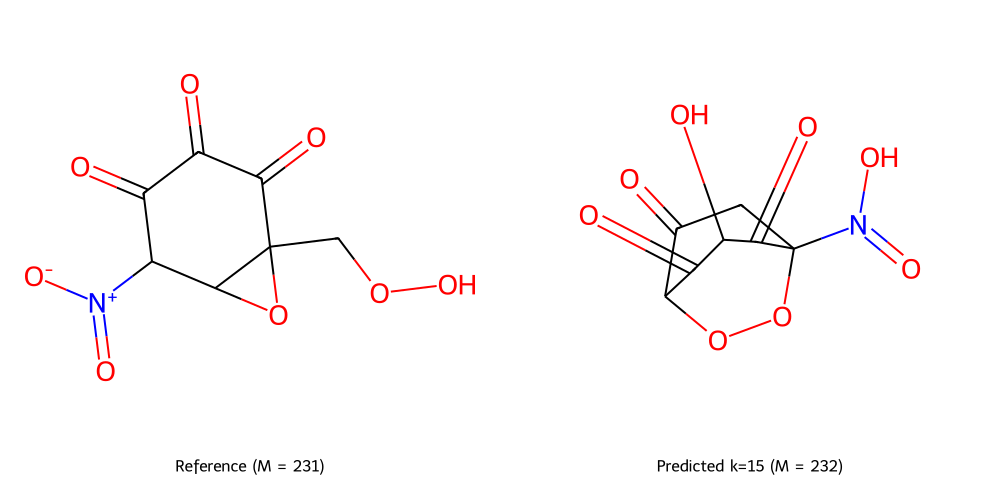

In [511]:
mol2 = next(mols2)
mol2_idx = next(mols2_idx)
molwt1, molwt2 = round(ExactMolWt(mol1)), round(ExactMolWt(mol2))
print(f'{CalcMolFormula(mol1)}, {CalcMolFormula(mol2)}')
legends = [f'Reference (M = {molwt1})', f'Predicted k={mol2_idx+1} (M = {molwt2})']
subImgSize = (500, 500)
Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=subImgSize, legends=legends)

In [512]:
# Set up the drawer
drawer = rdMolDraw2D.MolDraw2DCairo(2800, 500)  # width x height
drawer.drawOptions().legendFontSize = 35      # <-- increase font size here


drawer.DrawMolecule(mol1, legend=legends[0])
# Translate the drawing origin to the right for the second molecule
drawer.SetOffset(800, 0)
drawer.DrawMolecule(mol2, legend=legends[1])

drawer.FinishDrawing()
with open('molecules.png', 'wb') as f:
    f.write(drawer.GetDrawingText())

# Load with PIL
img = Image.open('molecules.png')

# Create a white background image
bg = Image.new(img.mode, img.size, (255, 255, 255))

# Calculate difference
diff = ImageChops.difference(img, bg)

# Enhance difference to highlight non-white areas
bbox = diff.getbbox()

if bbox:
    cropped_img = img.crop(bbox)
    cropped_img.show()  # display cropped image
    cropped_img.save('molecules.png')
else:
    print("No non-white area detected; image may already be fully cropped.")

In [16]:
raise Exception

Exception: 

In [ ]:
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

In [ ]:
mols = df['mol'].values
fps = [morgan_generator.GetFingerprint(mol) for mol in tqdm(mols, desc="Computing fingerprints")]

num_dupes = 0
n = len(fps)
for i in tqdm(range(n), desc="Checking for duplicates"):
    for j in range(i + 1, n):
        if TanimotoSimilarity(fps[i], fps[j]) == 1.0:
            num_dupes += 1  

Checking for duplicates:   1%|          | 1593/166434 [03:23<5:51:18,  7.82it/s]


KeyboardInterrupt: 

In [ ]:
print(num_dupes)